In [102]:
import numpy as np
from SALib.sample.sobol import sample
from SALib.analyze.sobol import analyze
from Classes.Analysis import Analysis
from Classes.Visualizer import Visualizer
from Classes.Math import optical_density
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy
# # use base class Analysis to create a new class System
class System(Analysis):
    def __init__(self, graph_location):
        """The ODE representation of the Golding Model from 'Using population dynamics to count bacteriophages and their Golding' from Yuncong Geng, Thu Vu Phuc Nguyen, Ehsan Homaee, and Ido Golding. 
        Uses Classes.Analysis as a base class. 
        Args:
            graph_location (str): location of the graph file
        """
        super().__init__(graph_location)

    def odesystem(self, t, Y, *params):
        """The sytem of ODEs that represent the Golding Model.
        Args:
            t (float): The time value that the solver is currently at.
            Y (np.array): The initial (for t=0)/current (for t>0) population values of the system. A 1D array of length equal to the number of variables in the system.
        """
        def g(R, v, K):
            """Calculate the growth rate of the bacteria. The growth rate is a function of the concentration of the resource, the growth rate of the bacteria, and the carrying capacity of the bacteria.
            Args:
                R (float): Resource concentration
                v (float): max rate of growth
                K (float): carrying capacity
            Returns:
                float: The growth rate of the bacteria. v*R/(R+K)
            """
            return (R * v) / (R + K)
        # Unpack the parameters. Need to get the graph network, the list of phage/bacteria/resource node names, value of M, the vectors (tau and washin), and the matrices (e, v, K, r, B), and the environment settings
        graph_object, phage_nodes, bacteria_nodes, resource_nodes, M, tau_vector, washin_vector, e_matrix, v_matrix, K_matrix, r_matrix, B_matrix, environment = params
        graph = graph_object.graph
        Y = self.check_cutoff(Y) # check to see if any values are really small. If yes, set to 0
        R, U, I, P = self.unflatten_initial_matrix(Y, [len(resource_nodes), len(bacteria_nodes), (len(bacteria_nodes), M), len(phage_nodes)]) # Turn Y into the shape of the system. 
        new_R = np.zeros_like(R) # create fresh copies of the arrays to be updated. 
        new_U = np.zeros_like(U)
        new_I = np.zeros_like(I)
        new_P = np.zeros_like(P)
        
        #update N vector
        for resource in resource_nodes: # loop over the resource names
            r_index = resource_nodes.index(resource) # get the index of the phage
            washin = washin_vector[r_index]
            sum = 0
            for bacteria in bacteria_nodes: # loop over the bacteria names
                b_index = bacteria_nodes.index(bacteria)
                if graph.has_edge(bacteria, resource): # important to check if the edge between bacteria_b and resource_r exists.
                    e = e_matrix[b_index, r_index] # get the associated values for this interaction
                    v = v_matrix[b_index, r_index]
                    K = K_matrix[b_index, r_index]
                    U_b = U[b_index] # uninfected
                    I_b = np.sum(I[b_index]) # sum of all infected bacteria b agents
                    sum += e * g(R[r_index], v, K) * (U_b + I_b) 
            new_R[r_index] = -sum - R[r_index] * environment['washout'] + washin # calculate the new value of the resource.
        
        # update U vector
        for uninfected_bacteria in bacteria_nodes:
            u_index = bacteria_nodes.index(uninfected_bacteria)
            p_sum = 0
            g_sum = 0
            for resource in resource_nodes: # loop over the resource names
                r_index = resource_nodes.index(resource) # get index of the resource
                if graph.has_edge(uninfected_bacteria, resource):
                    g_sum += g(R[r_index], v_matrix[u_index, r_index], K_matrix[u_index, r_index])
            for phage in phage_nodes: # loop over the phage names
                p_index = phage_nodes.index(phage) # get index of the phage
                if graph.has_edge(phage, uninfected_bacteria): # check if the edge between phage_p and bacteria_b exists.
                    p_sum += r_matrix[p_index, u_index] * P[p_index]
            # update the uninfected bacteria
            new_U[u_index] = U[u_index] * g_sum - U[u_index] * p_sum - U[u_index] * environment['washout']

        # update I vector
        for infected_bacteria in bacteria_nodes:
            i_index = bacteria_nodes.index(infected_bacteria)
            for k_index in range(0, M):
                if k_index == 0: # if we are at the first stage of infection
                    p_sum = 0
                    for phage in phage_nodes: # loop over the phage names
                        p_index = phage_nodes.index(phage) # get index of the phage
                        if graph.has_edge(phage, infected_bacteria): # check if the edge between phage_p and bacteria_b exists.
                            p_sum += r_matrix[p_index, i_index] * P[p_index]
                        M_tau = 0 if tau_vector[i_index] == 0 else M / tau_vector[i_index]
                    new_I[i_index, 0] = U[i_index] * p_sum - M_tau * I[i_index, 0] - environment['washout'] * U[i_index]
                else: # if we are at the other stages of infection
                    if(tau_vector[i_index] == 0): # prevent divide by 0 error
                        M_tau = 0
                    else:
                        m_tau = M / tau_vector[i_index] # get the value of M_tau
                    right = I[i_index, k_index - 1] - I[i_index, k_index]
                    new_I[i_index, k_index] = m_tau * right - environment['washout'] * new_I[i_index, k_index] 
        
        # update P vector
        for phage in phage_nodes: # loop over the phage names
            p_index = phage_nodes.index(phage) # get index of the phage
            left_sum = 0 # initialize sums
            right_sum = 0
            for infected_bacteria in bacteria_nodes: # loop over the bacteria names
                i_index = bacteria_nodes.index(infected_bacteria) # get index of the bacteria
                if graph.has_edge(phage, infected_bacteria): # check if the edge between phage_p and bacteria_b exists.
                    if (tau_vector[i_index] == 0): # prevent divide by 0 error
                        M_tau = 0
                    else:
                        M_tau = M / tau_vector[i_index] # get the value of M_tau
                    left_sum += B_matrix[p_index, i_index] * M_tau * I[i_index, -1]
                    right_sum += r_matrix[p_index, i_index] * (U[i_index] + np.sum(I[i_index]))
            # update the phage value
            new_P[p_index] = left_sum - right_sum * P[p_index] - environment['washout'] * P[p_index]
        # flatten the new updated initial conditions, undoes the flattening done by unflatten_initial_matrix(). 
        flattened_y1 = self.flatten_lists_and_matrices(new_R, new_U, new_I, new_P)
        return flattened_y1

# graph = GraphMakerGUI(seed=0) # create a new object using the GUI tool. 
system = System('simple_graph.gexf') # load the graph from the file.

phage_nodes = system.get_nodes_of_type('P') # get the phage nodes
bacteria_nodes = system.get_nodes_of_type('B') # get the bacteria nodes
resource_nodes = system.get_nodes_of_type('R') # get the resource nodes
environment_nodes = system.get_nodes_of_type('E') # get the environment nodes

# get the 'Initial_Condition' attribute values from the nodes. Saves as vector. 
R0 = system.initialize_new_parameter_from_node("Initial_Concentration", resource_nodes)
U0 = system.initialize_new_parameter_from_node("Initial_Population", bacteria_nodes)
I0 = system.initialize_new_matrix(len(U0), system.M)
P0 = system.initialize_new_parameter_from_node("Initial_Population", phage_nodes)
# get the 'tau' and 'washin' values from the bacteria and resource nodes. Saves as vector
tau_vector = system.initialize_new_parameter_from_node('tau', bacteria_nodes)
washin = system.initialize_new_parameter_from_node('washin', resource_nodes)

# get the 'e', 'v', 'K', 'r', and 'B' values from the edges between the listed nodes. Saves as matrix.
e_matrix = system.initialize_new_parameter_from_edges('e', bacteria_nodes, resource_nodes)
v_matrix = system.initialize_new_parameter_from_edges('v', bacteria_nodes, resource_nodes)
K_matrix = system.initialize_new_parameter_from_edges('K', bacteria_nodes, resource_nodes)
r_matrix = system.initialize_new_parameter_from_edges('r', phage_nodes, bacteria_nodes)
B_matrix = system.initialize_new_parameter_from_edges('Burst_Size', phage_nodes, bacteria_nodes)

visualizer = Visualizer(system) # start the visualizer system. 

# add the initial conditions to the visualizer, with a name, the initial conditions, and the node names.
visualizer.add_graph_data("Resources", R0, resource_nodes)
# create an uninfected 'hidden' agent
visualizer.add_graph_data("Uninfected Bacteria", U0, bacteria_nodes)
# create infected 'hidden' agent. provide row names, as well as column names.
visualizer.add_graph_data("Infected Bacteria", I0, row_names=bacteria_nodes, column_names=[f"Infected B{i}" for i in range(int(4))], add_rows=4)
visualizer.add_graph_data("Phages", P0, phage_nodes)

# add the vector parameters to the visualizer, with a name, the parameter values, and the node names.
visualizer.add_non_graph_data_vector("tau_vector", tau_vector, bacteria_nodes)
visualizer.add_non_graph_data_vector("washin", washin, resource_nodes)

# add matrix parameters to the visualizer, with a name, the parameter values, and the node names.
visualizer.add_non_graph_data_matrix("e_matrix", e_matrix, bacteria_nodes, resource_nodes)
visualizer.add_non_graph_data_matrix("v_matrix", v_matrix, bacteria_nodes, resource_nodes)
visualizer.add_non_graph_data_matrix("K_matrix", K_matrix, bacteria_nodes, resource_nodes)
visualizer.add_non_graph_data_matrix("r_matrix", r_matrix, phage_nodes, bacteria_nodes)
visualizer.add_non_graph_data_matrix("B_matrix", B_matrix, phage_nodes, bacteria_nodes)

# optionally add other parameters to the visualizer, that will be passed to the ODE system.
visualizer.add_other_parameters(phage_nodes, bacteria_nodes, resource_nodes, int(system.M))

In [86]:
file_location_full = 'SimulationResults/SensitivityAnalysis/SOBOLAnalysisWithWiWo/SOBOL_analysis_full_data_1749149674.pickle'
timestamp = file_location_full.split('.')[0].split('_')[-1]
with open(file_location_full, 'rb') as f:
    sensitivity_data = pickle.load(f)
print(sensitivity_data.keys())
t_values, y_values = sensitivity_data['t_values'], sensitivity_data['y_values']
problem_spec = sensitivity_data['problem_spec']
SOBOL_number_samples = sensitivity_data['SOBOL_number_samples']
SOBOL_2nd_order = sensitivity_data['SOBOL_2nd_order']
seed = sensitivity_data['seed']
param_samples = sample(problem_spec, 2**SOBOL_number_samples, calc_second_order=SOBOL_2nd_order, seed=int(seed))
data_size = sensitivity_data['data_size']
graph_data_keys = sensitivity_data['graph_data_keys']
t_eval_steps = sensitivity_data['t_eval_steps']
Y_peak_value = np.zeros((len(param_samples), len(data_size)+1))
Y_peak_time = np.zeros((len(param_samples), len(data_size)+1))
for key, value in sensitivity_data.items():
    if key in ["problem_spec", "y_final", "y_avg", "y_var", "final_analyzed", "avg_analyzed", "var_analyzed",  "graph_data", "non_graph_data_vector", "non_graph_data_matrix", "settings", "t_values", "y_values", "t_eval_steps"]:
        continue
    else:
        print(key, value)


dict_keys(['seed', 'number_variables', 'parameter_names', 'parameter_value_bounds', 'problem_spec', 't_eval_steps', 'y_final', 'y_avg', 'y_var', 'final_analyzed', 'avg_analyzed', 'var_analyzed', 'param_samples', 'SOBOL_2nd_order', 'SOBOL_number_samples', 'SOBOL_number_samples_tested', 'data_size', 'graph_data_keys', 'vector_data_keys', 'matrix_data_keys', 'initial_condition', 'non_graphing_data_vectors', 'non_graphing_data_matrices', 'settings', 'environment_data', 'other_parameters', 't_values', 'y_values'])
seed 0
number_variables 11
parameter_names ['Resources', 'Uninfected Bacteria', 'Phages', 'tau_vector', 'washin', 'e_matrix', 'v_matrix', 'K_matrix', 'r_matrix', 'B_matrix', 'washout']
parameter_value_bounds [[1.0, 500.0], [1.0, 100.0], [1.0, 50.0], [0.5, 3.5], [0.0, 100.0], [0.05, 0.25], [0.8, 1.9], [10.0, 250.0], [0.001, 0.2], [0.0, 100.0], [0.0, 0.1]]
param_samples [[4.25442148e+02 9.32052345e+01 1.87731619e+01 ... 3.81683465e-02
  8.65580074e+01 8.75151992e-02]
 [4.97333976e+0

In [103]:
def create_sobol_plot(analyzed, parameter_names, timestamp, title, save=True):
    fig, axs = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle(f'Total (ST) and First Order (S1) Sobol Sensitivity Analysis \n for {title} Value of Simulation \nfor Resources, Phages, and Total Bacteria', fontsize=20)
    list_of_output = ['Resources', 'Phages', 'Total Bacteria']
    indices_to_plot = [0, 3, 4] 
    
    for plot_idx, i in enumerate(indices_to_plot):
        analyzed_item = analyzed[i]
        St = analyzed_item['ST']
        St_conf = analyzed_item['ST_conf']
        S1 = analyzed_item['S1']
        S1_conf = analyzed_item['S1_conf']
        width = 0.35
        x = np.arange(len(parameter_names))
        axs[plot_idx].bar(x - width/2, St, width, yerr=St_conf, capsize=5, label='ST')
        axs[plot_idx].bar(x + width/2, S1, width, yerr=S1_conf, capsize=5, label='S1')
        axs[plot_idx].set_ylabel('Sensitivity', fontsize=14)
        axs[plot_idx].set_title(f'Sobol Indices for {list_of_output[plot_idx]} - {title} Value', fontsize=16)
        axs[plot_idx].tick_params(axis='y', labelsize=14)
        if plot_idx == len(indices_to_plot) - 1:
            axs[plot_idx].set_xticks(x)
            axs[plot_idx].set_xticklabels(parameter_names, rotation=-45, ha='left', fontsize=14)
        else:
            axs[plot_idx].set_xticks([])
        axs[plot_idx].grid(True, axis='y', linestyle='--', alpha=0.7)
        axs[plot_idx].minorticks_on()
        axs[plot_idx].grid(True, which='minor', axis='y', linestyle=':', alpha=0.4)
        if plot_idx == 0:
            axs[plot_idx].legend(fontsize=14)
        y_range = axs[plot_idx].get_ylim()
        print(f"Plot {plot_idx + 1} Y axis range:", y_range)

    fig.tight_layout()
    if save:
        title = title.replace(' ', '_')
        fig.savefig(f'LatexReport/Images/Plots/Created/SOBOL/SOBOL_analysis_{timestamp}_{title}.png', dpi=300, bbox_inches = 'tight')

In [88]:
new_list_y_values = []
for i, y_value in enumerate(y_values): 
    if i % 10000 == 0:
        print(i, len(y_values))
    overall_y = system.unflatten_initial_matrix(y_value, data_size)
    overall_y = visualizer.save_data(overall_y, t_values)
    overall_y.append([optical_density(deepcopy(overall_y), graph_data_keys)])
    new_list_y_values.append(overall_y)
    for j, data in enumerate(overall_y):
        max_val = np.max(data)
        threshold = 0.95 * max_val
        idx = np.argmax(data >= threshold)
        time_at_95 = t_values[idx] if idx < len(t_values) else None
        Y_peak_value[i, j] = threshold
        Y_peak_time[i, j] = time_at_95
Y_peak_value_analyzed = []
Y_peak_time_analyzed = []
for i in range(Y_peak_value.shape[1]):
    Y_peak_value_analyzed.append(analyze(problem_spec, Y_peak_value[:, i], calc_second_order=SOBOL_2nd_order))
    Y_peak_time_analyzed.append(analyze(problem_spec, Y_peak_time[:, i], calc_second_order=SOBOL_2nd_order))
# Calculate covariance and correlation between peak value and peak time for each output
covariances = []
correlations = []
for i in range(Y_peak_value.shape[1]):
    cov = np.cov(Y_peak_value[:, i], Y_peak_time[:, i])[0, 1]
    corr = np.corrcoef(Y_peak_value[:, i], Y_peak_time[:, i])[0, 1]
    covariances.append(cov)
    correlations.append(corr)
print("Covariances between peak value and peak time for each output:", covariances)
print("Correlations between peak value and peak time for each output:", correlations)


0 425984
10000 425984
20000 425984
30000 425984
40000 425984
50000 425984
60000 425984
70000 425984
80000 425984
90000 425984
100000 425984
110000 425984
120000 425984
130000 425984
140000 425984
150000 425984
160000 425984
170000 425984
180000 425984
190000 425984
200000 425984
210000 425984
220000 425984
230000 425984
240000 425984
250000 425984
260000 425984
270000 425984
280000 425984
290000 425984
300000 425984
310000 425984
320000 425984
330000 425984
340000 425984
350000 425984
360000 425984
370000 425984
380000 425984
390000 425984
400000 425984
410000 425984
420000 425984


/Users/vicpi/Documents/GitHub/Master-Thesis/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



Covariances between peak value and peak time for each output: [955.1853925492409, 4530.098452515235, 446.25745443584634, 230.18985946677117, 4368.544714712526]
Correlations between peak value and peak time for each output: [0.5231992226812437, 0.785778524052383, 0.5757328745210735, 0.04430427445163255, 0.7725102782316612]


Plot 1 Y axis range: (-0.029685276149846045, 0.6211284751076191)
Plot 2 Y axis range: (-0.059482774191325985, 1.0329653741779588)
Plot 3 Y axis range: (-0.042773718485516574, 0.6692456653532018)


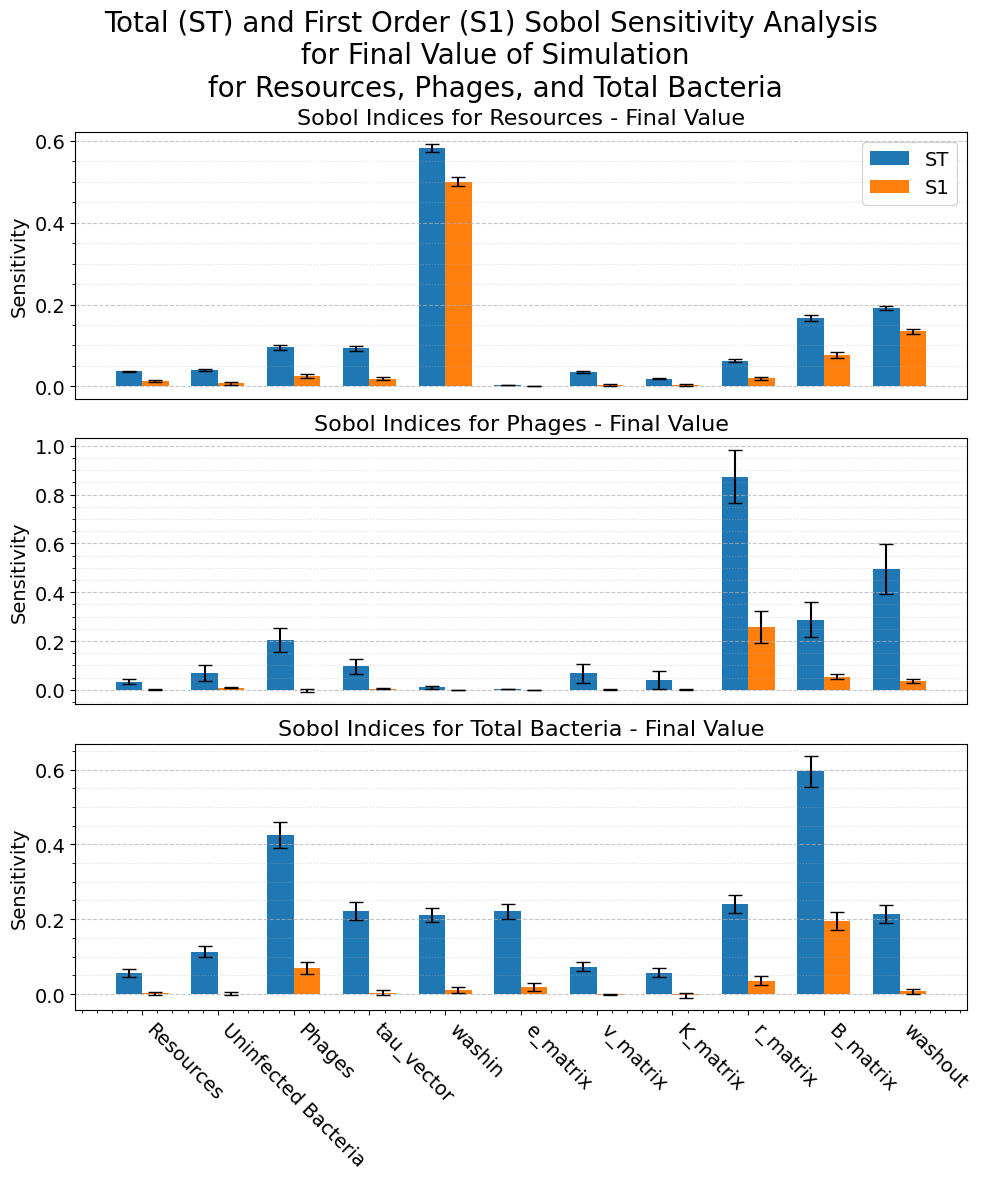

In [104]:
parameter_names = sensitivity_data['parameter_names']
final_analyzed = sensitivity_data['final_analyzed']
create_sobol_plot(final_analyzed, parameter_names, timestamp, "Final")

Plot 1 Y axis range: (0.0, 0.7249494877214258)
Plot 2 Y axis range: (-0.05549810979124685, 1.0096247552140671)
Plot 3 Y axis range: (-0.03371444829278128, 0.61218373627298)


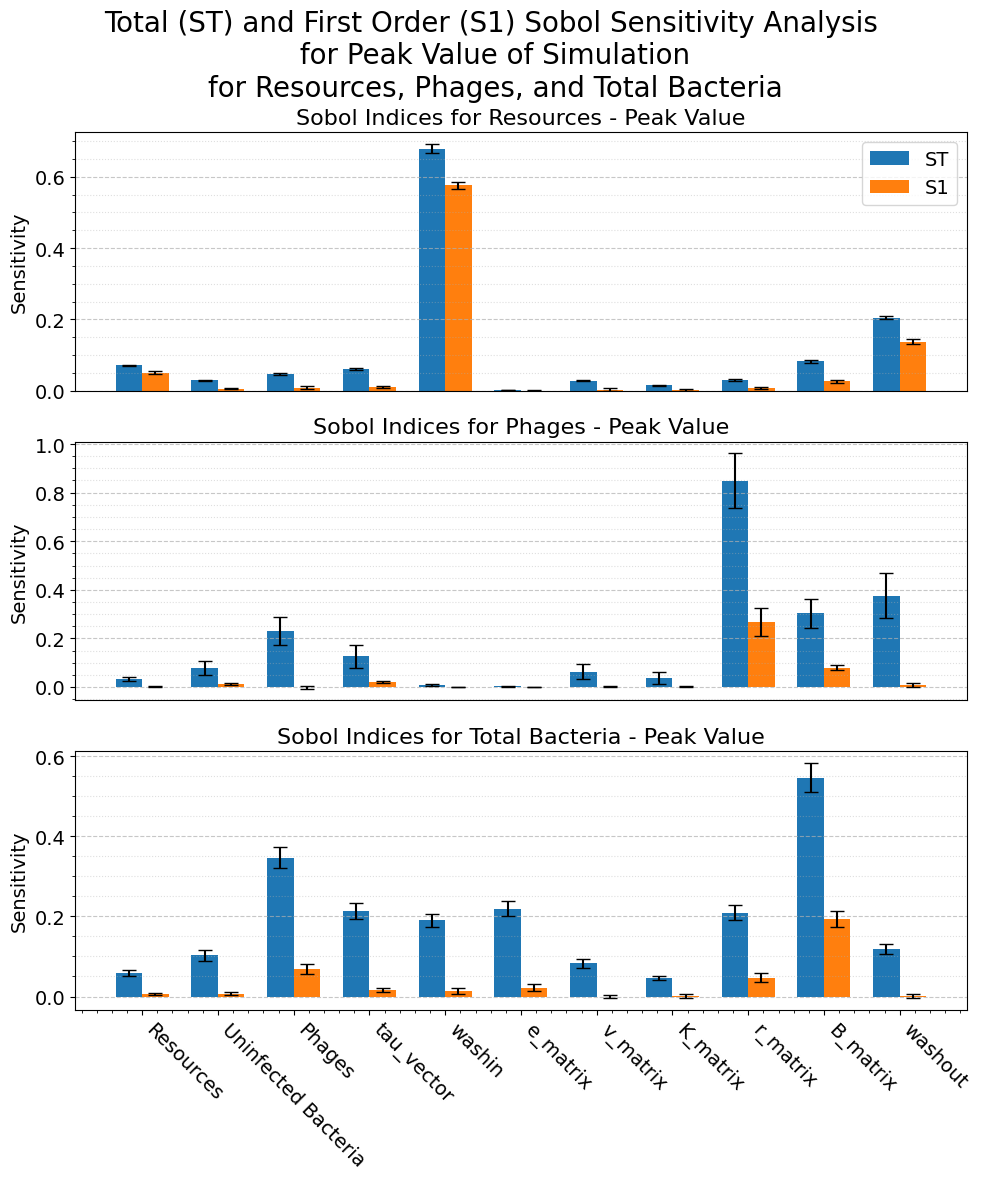

In [105]:
create_sobol_plot(Y_peak_value_analyzed, parameter_names, timestamp, "Peak")

Plot 1 Y axis range: (-0.03377830680252333, 0.6145270695579307)
Plot 2 Y axis range: (-0.04245493043924594, 0.7043538726555164)
Plot 3 Y axis range: (-0.028476631014798002, 0.5425981614993651)


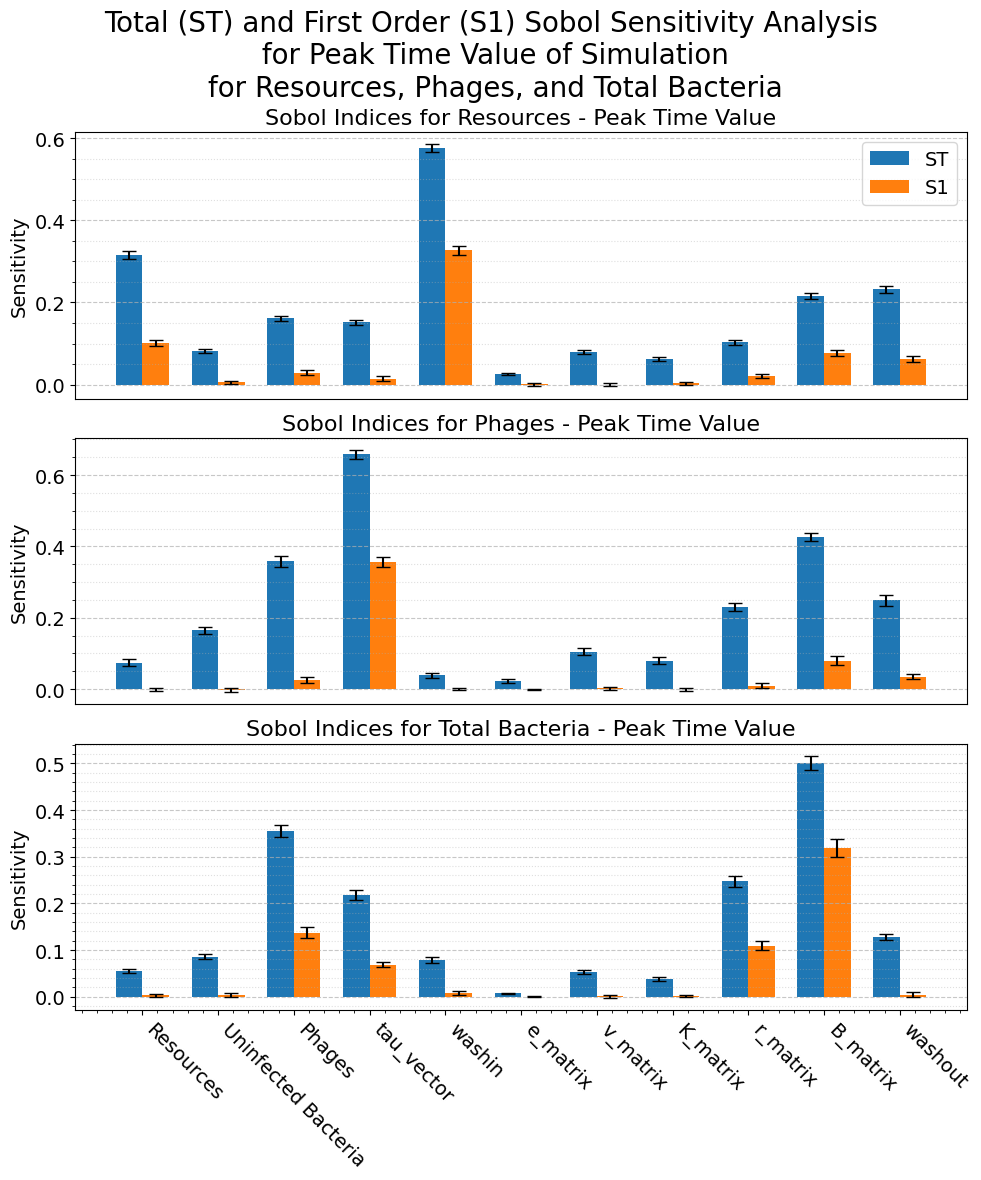

In [106]:
create_sobol_plot(Y_peak_time_analyzed, parameter_names, timestamp, "Peak Time")

In [92]:
file_location_full_new = 'SimulationResults/SensitivityAnalysis/SOBOLAnalysisWithoutWiWo/SOBOL_analysis_full_data_1749708738.pickle'
timestamp_new = file_location_full_new.split('.')[0].split('_')[-1]
with open(file_location_full_new, 'rb') as f:
    sensitivity_data_new = pickle.load(f)
print(sensitivity_data_new.keys())
t_values_new, y_values_new = sensitivity_data_new['t_values'], sensitivity_data_new['y_values']
problem_spec_new = sensitivity_data_new['problem_spec']
SOBOL_number_samples_new = sensitivity_data_new['SOBOL_number_samples']
SOBOL_2nd_order_new = sensitivity_data_new['SOBOL_2nd_order']
seed_new = sensitivity_data_new['seed']
param_samples_new = sample(problem_spec_new, 2**SOBOL_number_samples_new, calc_second_order=SOBOL_2nd_order_new, seed=int(seed_new))
data_size_new = sensitivity_data_new['data_size']
graph_data_keys_new = sensitivity_data_new['graph_data_keys']
t_eval_steps_new = sensitivity_data_new['t_eval_steps']
Y_peak_value_new = np.zeros((len(param_samples_new), len(data_size_new)+1))
Y_peak_time_new = np.zeros((len(param_samples_new), len(data_size_new)+1))
for key_new, value_new in sensitivity_data_new.items():
    if key_new in ["problem_spec", "y_final", "y_avg", "y_var", "final_analyzed", "avg_analyzed", "var_analyzed",  "graph_data", "non_graph_data_vector", "non_graph_data_matrix", "settings", "t_values", "y_values", "t_eval_steps"]:
        continue
    else:
        print(key_new, value_new)


dict_keys(['seed', 'number_variables', 'parameter_names', 'parameter_value_bounds', 'problem_spec', 't_eval_steps', 'y_final', 'y_avg', 'y_var', 'final_analyzed', 'avg_analyzed', 'var_analyzed', 'param_samples', 'SOBOL_2nd_order', 'SOBOL_number_samples', 'SOBOL_number_samples_tested', 'data_size', 'graph_data_keys', 'vector_data_keys', 'matrix_data_keys', 'initial_condition', 'non_graphing_data_vectors', 'non_graphing_data_matrices', 'settings', 'environment_data', 'other_parameters', 't_values', 'y_values'])
seed 0
number_variables 9
parameter_names ['Resources', 'Uninfected Bacteria', 'Phages', 'tau_vector', 'e_matrix', 'v_matrix', 'K_matrix', 'r_matrix', 'B_matrix']
parameter_value_bounds [[1.0, 500.0], [1.0, 100.0], [1.0, 50.0], [0.5, 3.5], [0.05, 0.25], [0.8, 1.9], [10.0, 250.0], [0.001, 0.2], [1.0, 100.0]]
param_samples [[4.25442148e+02 9.32052345e+01 1.87731619e+01 ... 1.11408307e+02
  7.84532805e-02 1.94907855e+01]
 [4.32924457e+02 9.32052345e+01 1.87731619e+01 ... 1.11408307e+

In [93]:
new_list_y_values_new = []
for i, y_value_new in enumerate(y_values_new): 
    if i % 10000 == 0:
        print(i, len(y_values_new))
    overall_y_new = system.unflatten_initial_matrix(y_value_new, data_size_new)
    overall_y_new = visualizer.save_data(overall_y_new, t_values_new)
    overall_y_new.append([optical_density(deepcopy(overall_y_new), graph_data_keys_new)])
    new_list_y_values_new.append(overall_y_new)
    for j, data_new in enumerate(overall_y_new):
        max_val_new = np.max(data_new)
        threshold_new = 0.95 * max_val_new
        idx_new = np.argmax(data_new >= threshold_new)
        time_at_95_new = t_values_new[idx_new] if idx_new < len(t_values_new) else None
        Y_peak_value_new[i, j] = threshold_new
        Y_peak_time_new[i, j] = time_at_95_new
Y_peak_value_analyzed_new = []
Y_peak_time_analyzed_new = []
for i in range(Y_peak_value_new.shape[1]):
    Y_peak_value_analyzed_new.append(analyze(problem_spec_new, Y_peak_value_new[:, i], calc_second_order=SOBOL_2nd_order_new))
    Y_peak_time_analyzed_new.append(analyze(problem_spec_new, Y_peak_time_new[:, i], calc_second_order=SOBOL_2nd_order_new))
# Calculate covariance and correlation between peak value and peak time for each output
covariances_new = []
correlations_new = []
for i in range(Y_peak_value_new.shape[1]):
    cov_new = np.cov(Y_peak_value_new[:, i], Y_peak_time_new[:, i])[0, 1]
    corr_new = np.corrcoef(Y_peak_value_new[:, i], Y_peak_time_new[:, i])[0, 1]
    covariances_new.append(cov_new)
    correlations_new.append(corr_new)
print("Covariances between peak value and peak time for each output:", covariances_new)
print("Correlations between peak value and peak time for each output:", correlations_new)


0 360448
10000 360448
20000 360448
30000 360448
40000 360448
50000 360448
60000 360448
70000 360448
80000 360448
90000 360448
100000 360448
110000 360448
120000 360448
130000 360448
140000 360448
150000 360448
160000 360448
170000 360448
180000 360448
190000 360448
200000 360448
210000 360448
220000 360448
230000 360448
240000 360448
250000 360448
260000 360448
270000 360448
280000 360448
290000 360448
300000 360448
310000 360448
320000 360448
330000 360448
340000 360448
350000 360448
360000 360448


/Users/vicpi/Documents/GitHub/Master-Thesis/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



Covariances between peak value and peak time for each output: [0.0, 393.09373517728017, 378.20221201932344, -144.51338202733288, 468.36369326168204]
Correlations between peak value and peak time for each output: [nan, 0.6085268175016822, 0.48283545280773466, -0.019700996086167044, 0.5846136708130739]


Plot 1 Y axis range: (0.0, 0.72475762005102)
Plot 2 Y axis range: (-0.049620457647003506, 1.0295907682256524)
Plot 3 Y axis range: (-0.06399656964607324, 1.1878209860185684)


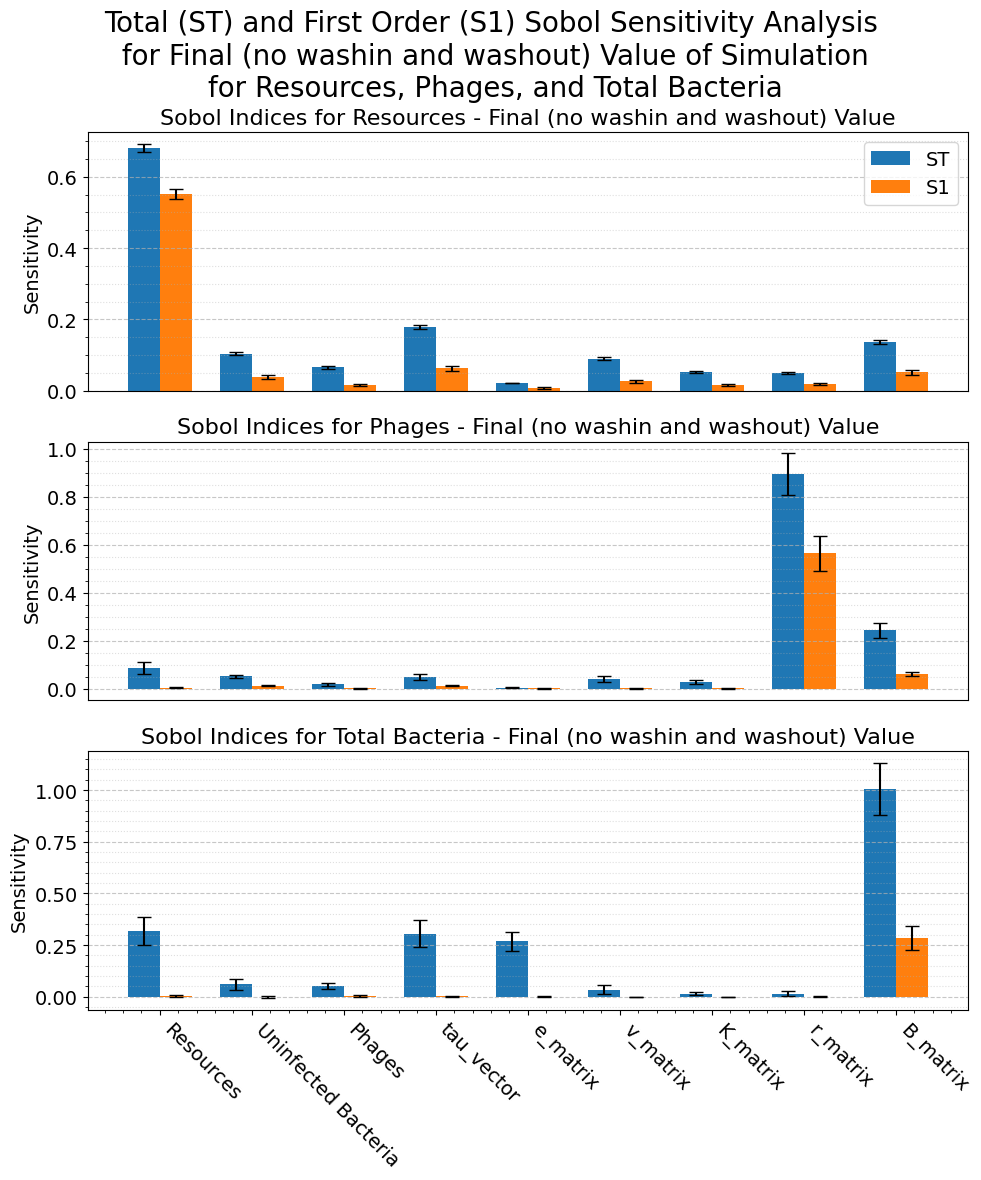

In [107]:
parameter_names_new = sensitivity_data_new['parameter_names']
final_analyzed_new = sensitivity_data_new['final_analyzed']
create_sobol_plot(final_analyzed_new, parameter_names_new, timestamp_new, "Final (no washin and washout)")

Plot 1 Y axis range: (0.0, 1.0638418177997184)
Plot 2 Y axis range: (-0.04924322079412848, 1.0257075775052862)
Plot 3 Y axis range: (0.0, 0.5990866961850069)


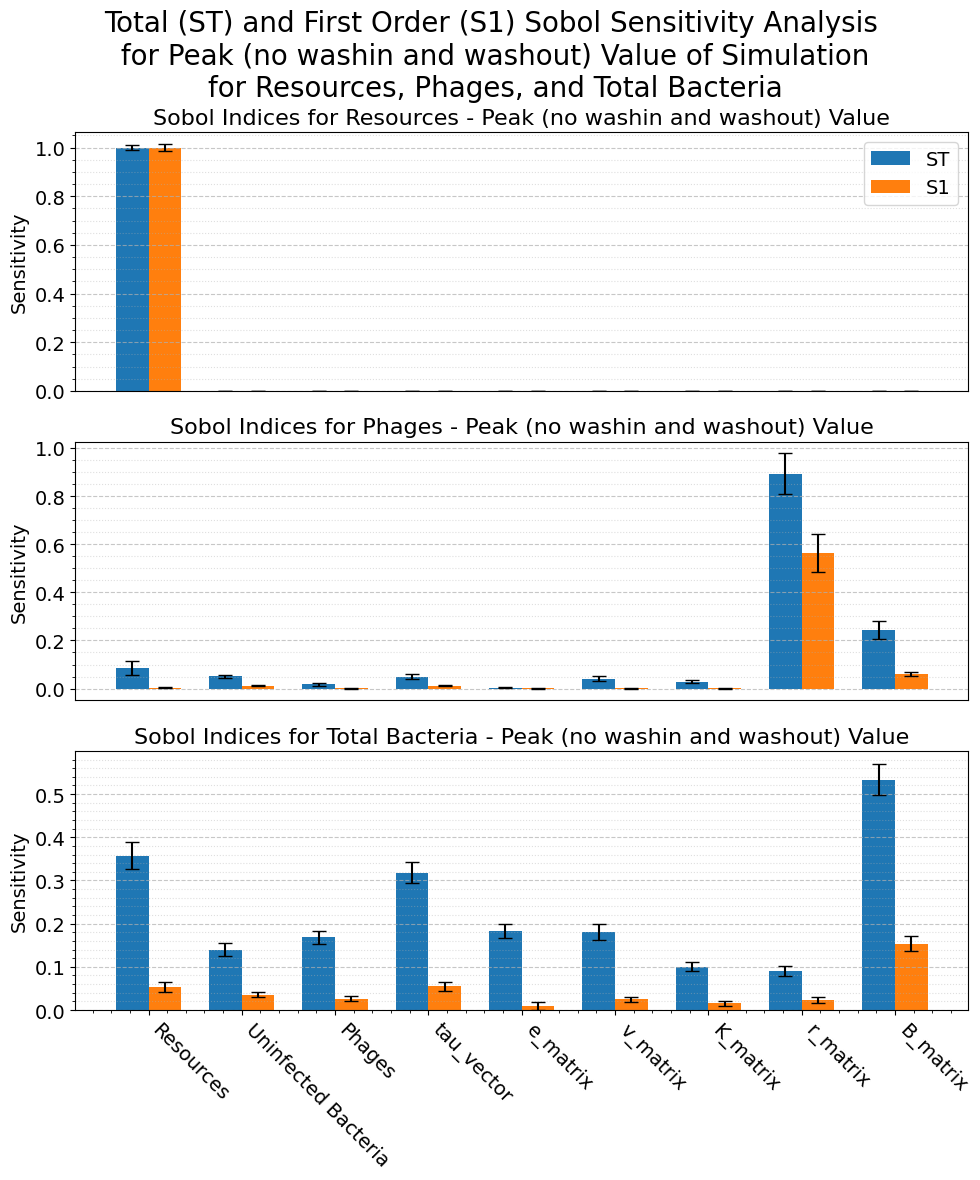

In [108]:
create_sobol_plot(Y_peak_value_analyzed_new, parameter_names_new, timestamp_new, "Peak (no washin and washout)")

Plot 1 Y axis range: (-0.05500000000000001, 0.05500000000000001)
Plot 2 Y axis range: (-0.040842906197515745, 0.8144902964850622)
Plot 3 Y axis range: (-0.028188464174517258, 0.5460960896888223)


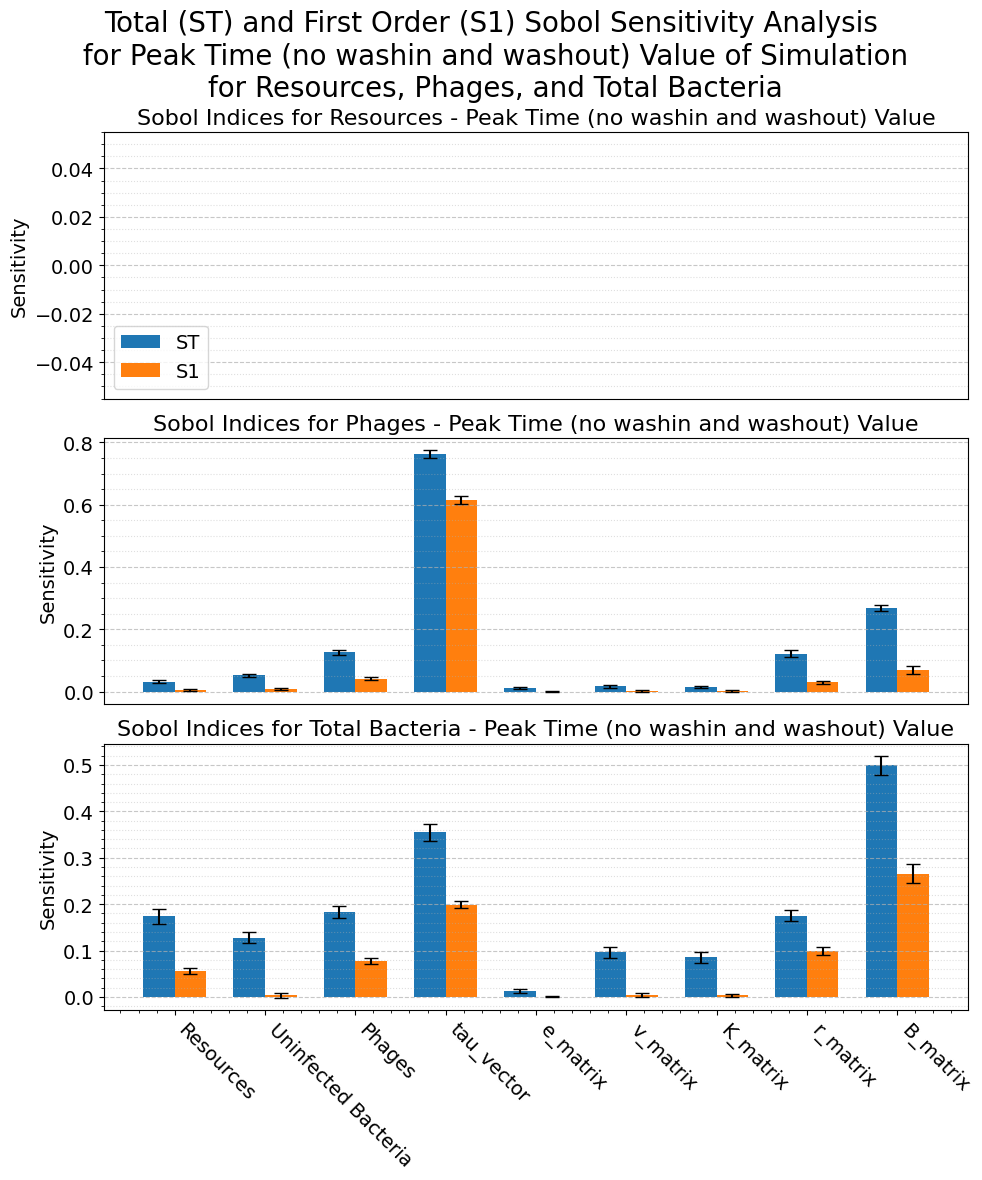

In [109]:
create_sobol_plot(Y_peak_time_analyzed_new, parameter_names_new, timestamp_new, "Peak Time (no washin and washout)")

In [115]:
def create_sobol_plot2(analyzed, parameter_names, timestamp, title, y_low, y_high, save=True):
    fig, axs = plt.subplots(3, 1, figsize=(3, 12))
    fig.suptitle(rf'ST and S1 Analysis for $\tau$', fontsize=20)
    list_of_output = ['Resources', 'Phages', 'Total Bacteria']
    indices_to_plot = [0, 3, 4] 
    parameter_names = [parameter_names[3]]
    for plot_idx, i in enumerate(indices_to_plot):
        analyzed_item = analyzed[i]
        St = analyzed_item['ST']
        St_conf = analyzed_item['ST_conf']
        S1 = analyzed_item['S1']
        S1_conf = analyzed_item['S1_conf']
        width = 0.35
        St = St[3]
        St_conf = St_conf[3]
        S1 = S1[3]
        S1_conf = S1_conf[3]
        print(parameter_names)
        x = np.arange(len(parameter_names))
        axs[plot_idx].bar(x - width/2, St, width, yerr=St_conf, capsize=5, label='ST')
        axs[plot_idx].bar(x + width/2, S1, width, yerr=S1_conf, capsize=5, label='S1')
        axs[plot_idx].set_ylabel('Sensitivity', fontsize=14)
        axs[plot_idx].set_title(f'{list_of_output[plot_idx]} - {title} Value', fontsize=16)
        axs[plot_idx].tick_params(axis='y', labelsize=14)
        if plot_idx == len(indices_to_plot) - 1:
            axs[plot_idx].set_xticks(x)
            axs[plot_idx].set_xticklabels(parameter_names, rotation=-45, ha='left', fontsize=14)
        else:
            axs[plot_idx].set_xticks([])
        axs[plot_idx].grid(True, axis='y', linestyle='--', alpha=0.7)
        axs[plot_idx].minorticks_on()
        axs[plot_idx].grid(True, which='minor', axis='y', linestyle=':', alpha=0.4)
        if plot_idx == 0:
            axs[plot_idx].legend(fontsize=14)
        axs[plot_idx].set_ylim(y_low[plot_idx], y_high[plot_idx])
    fig.tight_layout()
    if save:
        title = title.replace(' ', '_')
        fig.savefig(f'LatexReport/Images/Plots/Created/SOBOL/SOBOL_tau_zoomed_in_{timestamp}_{title}.png', dpi=300, bbox_inches = 'tight')

['tau_vector']
['tau_vector']
['tau_vector']


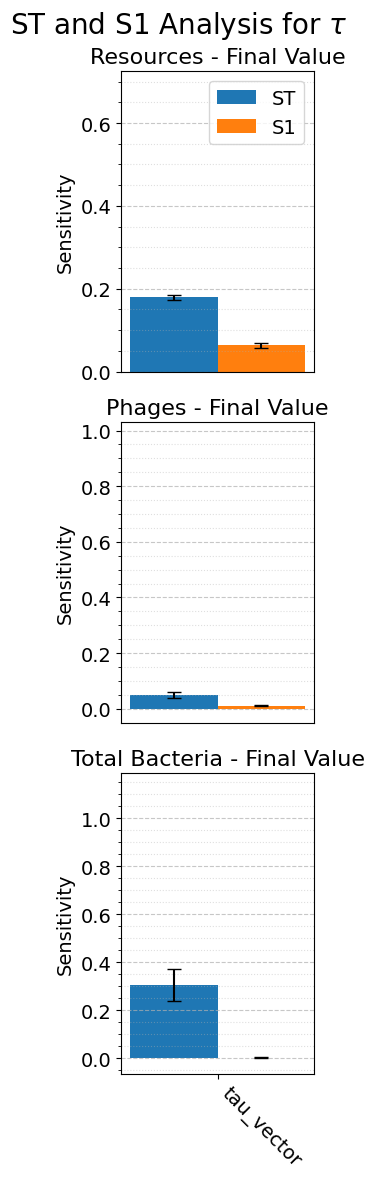

In [116]:
y_low = [0.0, -0.049620457647003506, -0.06399656964607324]
y_high = [0.72475762005102, 1.0295907682256524, 1.1878209860185684]
create_sobol_plot2(final_analyzed_new, parameter_names_new, timestamp_new, "Final", y_low, y_high)

['tau_vector']
['tau_vector']
['tau_vector']


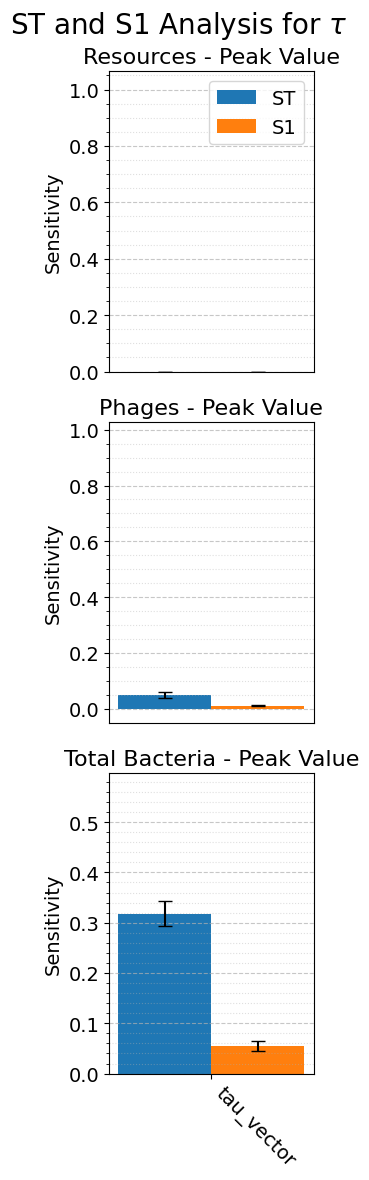

In [117]:
y_low = [0.0, -0.04943475892280569, 0.0]
y_high = [1.0645498368516528, 1.0263584638118517, 0.5968680353196804]

create_sobol_plot2(Y_peak_value_analyzed_new, parameter_names_new, timestamp_new, "Peak", y_low, y_high)

['tau_vector']
['tau_vector']
['tau_vector']


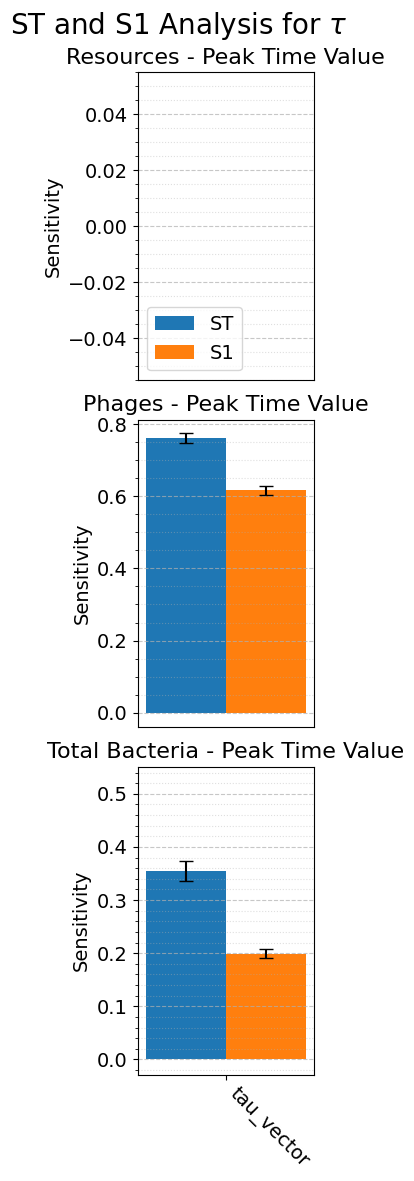

In [118]:
y_low = [-0.05500000000000001, -0.04080197027854499, -0.028531271025885742]
y_high = [0.05500000000000001, 0.8128822975233372, 0.5509549594141196]
create_sobol_plot2(Y_peak_time_analyzed_new, parameter_names_new, timestamp_new, "Peak Time", y_low, y_high)